In [1]:
import pandas as pd
import glob
import os
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import  Dropout
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import chi2_contingency
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("cleaned_traffic_data.csv")

In [4]:
# Define the final selected columns
selected_columns = [
    "Timestamp", "Station", "Route", "Direction of Travel",
    "Total Flow", "Avg Speed", "% Observed","Samples","Lane Type"
]

# Keep only the selected columns
df = df[selected_columns]

In [5]:
df.drop(columns=["Avg Speed"], inplace=True)

In [6]:
df = df[df['Total Flow'].notna()]

In [7]:
duplicates = df.index.duplicated().sum() #check the number of duplicates 
print("duplicates:", duplicates)

duplicates: 0


In [8]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True)

In [9]:
df

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
Timestamp,,,,,,,
2024-10-01 00:00:00,308512,50,W,497.0,0,197,ML
2024-10-01 00:00:00,311831,5,S,27.0,92,101,OR
2024-10-01 00:00:00,311832,5,S,78.0,92,101,FR
2024-10-01 00:00:00,311844,5,N,43.0,92,202,OR
2024-10-01 00:00:00,311847,5,N,73.0,92,303,OR
...,...,...,...,...,...,...,...
2024-12-31 23:00:00,3423094,99,S,68.0,96,118,ML
2024-12-31 23:00:00,3900021,50,E,803.0,67,292,ML
2024-12-31 23:00:00,3900022,50,E,509.0,0,0,HV


In [10]:
df["Station"].nunique() #There are 1,806 unique stations im the dataset 

1806

In [11]:
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Weekday'] = df.index.weekday
df["Month"] = df.index.month

In [12]:
df

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Hour,Day,Weekday,Month
Timestamp,,,,,,,,,,,
2024-10-01 00:00:00,308512,50,W,497.0,0,197,ML,0,1,1,10
2024-10-01 00:00:00,311831,5,S,27.0,92,101,OR,0,1,1,10
2024-10-01 00:00:00,311832,5,S,78.0,92,101,FR,0,1,1,10
2024-10-01 00:00:00,311844,5,N,43.0,92,202,OR,0,1,1,10
2024-10-01 00:00:00,311847,5,N,73.0,92,303,OR,0,1,1,10
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:00:00,3423094,99,S,68.0,96,118,ML,23,31,1,12
2024-12-31 23:00:00,3900021,50,E,803.0,67,292,ML,23,31,1,12
2024-12-31 23:00:00,3900022,50,E,509.0,0,0,HV,23,31,1,12


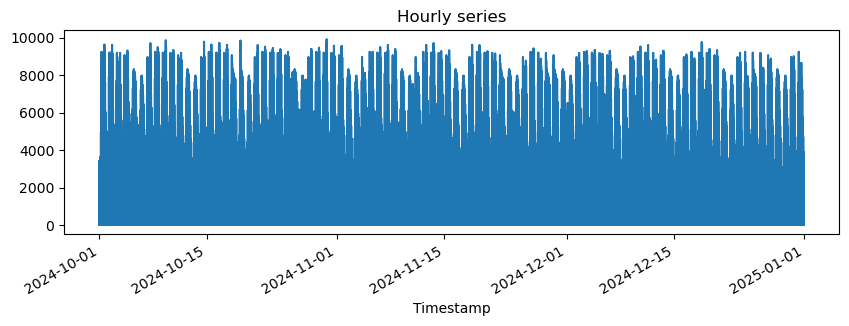

In [13]:
ax = df['Total Flow'].plot(figsize=(10,3), title='Hourly series') #from the plot there is both a daily and weekly strudture in the traffic flow 

<Axes: title={'center': 'Daily mean'}, xlabel='Timestamp'>

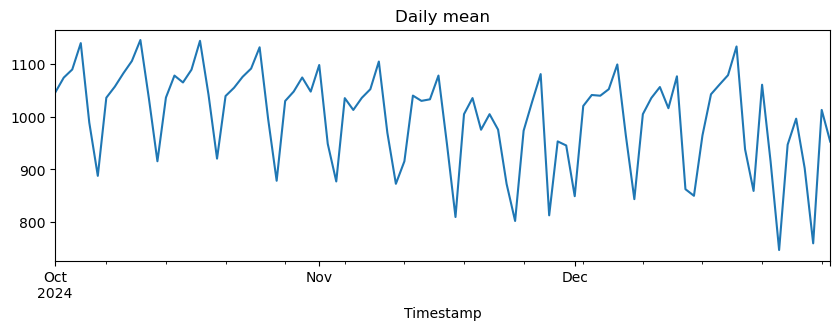

In [14]:
# daily average smooths noise so you see trend better
df['Total Flow'].resample('D').mean().plot(figsize=(10,3), title='Daily mean')


In [15]:
custom_holidays = [   ##Beacuse of the drop in december it is great to include holiday so our model lears the behaviour of the flow over that time or periods
    pd.to_datetime("2024-12-25"),
    pd.to_datetime("2024-12-31"),
    pd.to_datetime("2024-11-24"),
]
df['IsHoliday'] = df.index.to_series().apply(lambda x: 1 if x in custom_holidays else 0)

In [16]:
df.groupby('IsHoliday')['Total Flow'].mean()

IsHoliday
0    1000.285461
1     293.691938
Name: Total Flow, dtype: float64

The average hourly Total Flow during non-holiday periods is approximately 1000, whereas it drops to about 294 during holidays.

<Axes: title={'center': 'Average Total Flow: Holidays vs Non-Holidays'}, xlabel='IsHoliday (0=No, 1=Yes)', ylabel='Average Flow'>

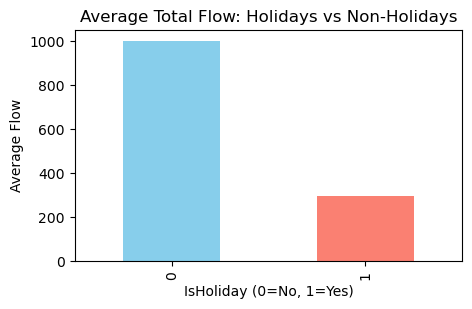

In [17]:
df.groupby('IsHoliday')['Total Flow'].mean().plot(
    kind='bar',
    color=['skyblue', 'salmon'],
    title='Average Total Flow: Holidays vs Non-Holidays',
    ylabel='Average Flow',
    xlabel='IsHoliday (0=No, 1=Yes)',
    figsize=(5,3)
)


In [18]:
# average value by hour of day
hour_profile = df.groupby('Hour')['Total Flow'].mean()
# average value by day of week
dow_profile  = df.groupby('Weekday')['Total Flow'].mean()

In [19]:
hour_profile

Hour
0      267.243212
1      195.949000
2      169.977573
3      205.348161
4      323.628788
5      623.516306
6     1009.907040
7     1289.505955
8     1316.575494
9     1300.455276
10    1360.537827
11    1429.879912
12    1499.280039
13    1533.003386
14    1614.258655
15    1669.942609
16    1657.396490
17    1583.645661
18    1330.434478
19    1037.403310
20     859.885616
21     733.225761
22     574.569621
23     401.395380
Name: Total Flow, dtype: float64

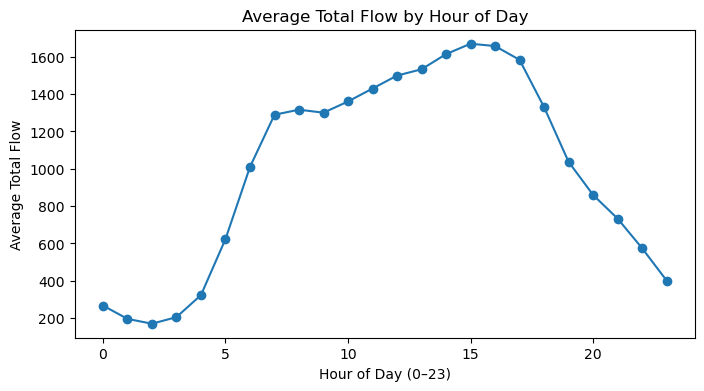

In [20]:
plt.figure(figsize=(8,4))
plt.plot(hour_profile.index, hour_profile.values, marker='o')
plt.title('Average Total Flow by Hour of Day')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Average Total Flow')
#plt.grid(True)
plt.show()


In [21]:
dow_profile

Weekday
0    1010.063746
1    1027.432555
2    1030.509575
3    1032.143192
4    1082.591190
5     953.854524
6     854.987151
Name: Total Flow, dtype: float64

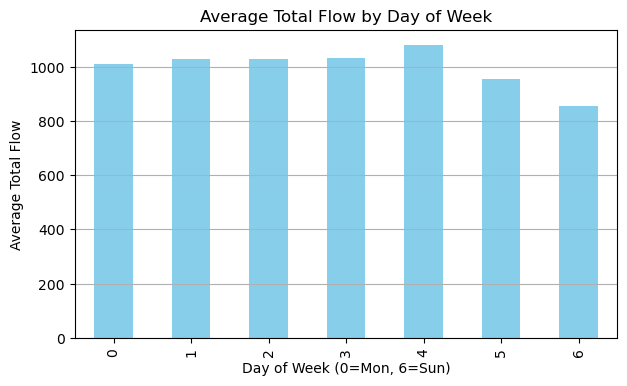

In [22]:
plt.figure(figsize=(7,4))
dow_profile.plot(kind='bar', color='skyblue')
plt.title('Average Total Flow by Day of Week')
plt.xlabel('Day of Week (0=Mon, 6=Sun)')
plt.ylabel('Average Total Flow')
plt.grid(axis='y')
plt.show()

In [23]:
for lag in range(1, 169):  # Lags 1 to 168
    df[f'TotalFlow_lag_{lag}'] = df['Total Flow'].shift(lag)

In [24]:
df.dropna(inplace=True)

In [25]:
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Weekday_sin'] = np.sin(2 * np.pi * df['Weekday'] / 7)
df['Weekday_cos'] = np.cos(2 * np.pi * df['Weekday'] / 7)

In [26]:
df = df.drop(columns=['Hour', 'Weekday'])

In [27]:
for window in [6, 12, 24, 168]:
    df[f'Flow_mean_{window}'] = df['Total Flow'].rolling(window=window).mean()
    df[f'Flow_std_{window}'] = df['Total Flow'].rolling(window=window).std()
    df[f'Flow_min_{window}'] = df['Total Flow'].rolling(window=window).min()
    df[f'Flow_max_{window}'] = df['Total Flow'].rolling(window=window).max()
    df[f'Flow_cv_{window}'] = df[f'Flow_std_{window}'] / df[f'Flow_mean_{window}']

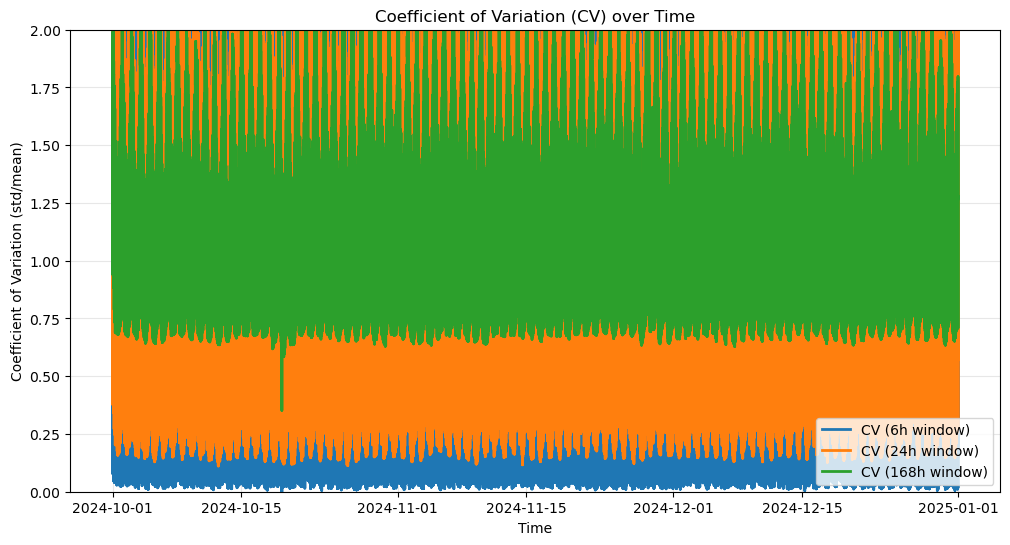

In [28]:
# Define windows to visualize
WINDOWS = [6, 12, 24, 168]
eps = 1e-6

# Compute rolling mean, std, and CV
for w in WINDOWS:
    m = df['Total Flow'].rolling(w).mean()
    s = df['Total Flow'].rolling(w).std()
    df[f'Flow_cv_{w}'] = s / m
    df.loc[m < 1.0, f'Flow_cv_{w}'] = np.nan  # avoid inflating CV when mean ≈ 0

# Plot CV over time
plt.figure(figsize=(12,6))

for w in [6, 24, 168]:  # show short, daily, and weekly
    plt.plot(df.index, df[f'Flow_cv_{w}'], label=f'CV ({w}h window)', linewidth=2)

plt.title('Coefficient of Variation (CV) over Time')
plt.xlabel('Time')
plt.ylabel('Coefficient of Variation (std/mean)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 2)  
plt.show()


Weekday
Monday       1.057653
Tuesday      1.058653
Wednesday    1.061878
Thursday     1.058368
Friday       1.036666
Saturday     1.040663
Sunday       1.062428
Name: Flow_cv_24, dtype: float64


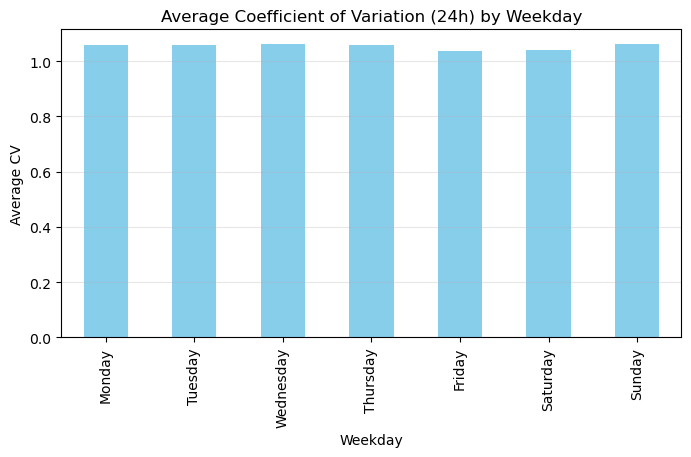

In [29]:
# Make sure 'Time' is your datetime index or column
df['Weekday'] = df.index.day_name()  # e.g., Monday, Tuesday...

# Choose the CV window you want to summarize (e.g., daily CV)
cv_col = 'Flow_cv_24'

weekday_cv = (
    df.groupby('Weekday')[cv_col]
      .mean()
      .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
)

print(weekday_cv)

# Plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
weekday_cv.plot(kind='bar', color='skyblue')
plt.title('Average Coefficient of Variation (24h) by Weekday')
plt.ylabel('Average CV')
plt.xlabel('Weekday')
plt.grid(axis='y', alpha=0.3)
plt.show()


| CV Value  | Interpretation     | Meaning for EV Flow                                                     |
| --------- | ------------------ | ----------------------------------------------------------------------- |
| 0.0 – 0.3 | Very stable        | Regular, predictable station                                            |
| 0.3 – 0.6 | Moderate variation | Normal daily cycles                                                     |
| 0.6 – 1.0 | High variation     | Irregular demand or events                                              |
| > 1.0     | Very unstable      | Flow fluctuates more than its mean


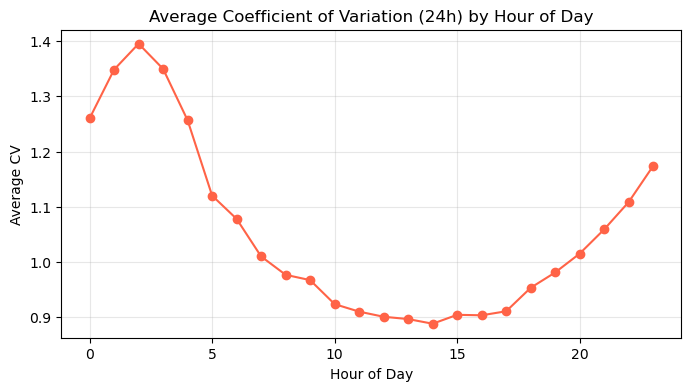

In [30]:
df['Hour'] = df.index.hour

hourly_cv = df.groupby('Hour')[cv_col].mean()

plt.figure(figsize=(8,4))
hourly_cv.plot(kind='line', marker='o', color='tomato')
plt.title('Average Coefficient of Variation (24h) by Hour of Day')
plt.ylabel('Average CV')
plt.xlabel('Hour of Day')
plt.grid(True, alpha=0.3)
plt.show()

In [31]:
station_cv = df.groupby('Station')[cv_col].mean().sort_values(ascending=False)

station_cv.head(10)  # top 10 most variable stations


Station
3054057    2.061905
3054056    2.033847
3054055    2.005207
3055025    1.984428
3423066    1.980683
3054053    1.962021
3054052    1.958693
3054054    1.909861
3055011    1.904669
3055015    1.902586
Name: Flow_cv_24, dtype: float64

CV values were highest during early-morning hours (00:00 – 05:00) when flow levels were minimal, indicating greater relative volatility. Flow became more stable during daylight hours (10:00 – 15:00) with CV values dropping below 1.0, suggesting consistent daytime demand. Variability increased again in the late evening, reflecting irregular activity outside standard commuting periods.

In [32]:
df.dropna(inplace=True)

In [33]:
df

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Day,Month,IsHoliday,...,Flow_min_24,Flow_max_24,Flow_cv_24,Flow_mean_168,Flow_std_168,Flow_min_168,Flow_max_168,Flow_cv_168,Weekday,Hour
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01 00:00:00,315053,5,N,44.0,92,99,OR,1,10,0,...,0.0,1327.0,1.113435,362.797619,376.802170,0.0,1381.0,1.038602,Tuesday,0
2024-10-01 00:00:00,315054,5,N,1004.0,92,394,ML,1,10,0,...,0.0,1327.0,1.029867,364.148810,378.698601,0.0,1381.0,1.039956,Tuesday,0
2024-10-01 00:00:00,315055,5,N,82.0,92,99,FR,1,10,0,...,0.0,1327.0,1.024410,364.559524,378.352744,0.0,1381.0,1.037835,Tuesday,0
2024-10-01 00:00:00,315060,5,S,32.0,92,141,ML,1,10,0,...,0.0,1327.0,1.098153,364.738095,378.187645,0.0,1381.0,1.036875,Tuesday,0
2024-10-01 00:00:00,315061,5,S,0.0,0,99,HV,1,10,0,...,0.0,1327.0,1.101467,356.529762,370.937571,0.0,1381.0,1.040411,Tuesday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:00:00,3423094,99,S,68.0,96,118,ML,31,12,0,...,0.0,506.0,1.513366,223.714286,287.966027,0.0,1422.0,1.287204,Tuesday,23
2024-12-31 23:00:00,3900021,50,E,803.0,67,292,ML,31,12,0,...,0.0,803.0,1.810561,222.434524,284.876139,0.0,1422.0,1.280719,Tuesday,23
2024-12-31 23:00:00,3900022,50,E,509.0,0,0,HV,31,12,0,...,0.0,803.0,1.651651,219.404762,279.010661,0.0,1422.0,1.271671,Tuesday,23


## LSTM MODEL
For each station, we build a LightGBM-selected LSTM model that uses lagged flows from other stations and contextual features to predict its own flow at multiple horizons, then average results across all stations.

In [34]:
summary = pd.DataFrame({
    'dtype': df.dtypes,
    'num_unique': df.nunique(),
    'example_values': df.apply(lambda x: list(x.unique()[:10]))  # show first 5 unique values
})


In [35]:
summary.sort_values('num_unique').head(50)

,dtype,num_unique,example_values
IsHoliday,int64,2,"[0, 1]"
Month,int32,3,"[10, 11, 12]"
Direction of Travel,object,4,"[N, S, E, W]"
Lane Type,object,5,"[OR, ML, FR, HV, FF]"
Weekday_cos,float64,7,"[0.6234898018587336, -0.22252093395631434, -0...."
Weekday_sin,float64,7,"[0.7818314824680298, 0.9749279121818236, 0.433..."
Weekday,object,7,"[Tuesday, Wednesday, Thursday, Friday, Saturda..."
Hour_sin,float64,21,"[0.0, 0.25881904510252074, 0.49999999999999994..."
Hour_cos,float64,22,"[1.0, 0.9659258262890683, 0.8660254037844387, ..."
Route,int64,23,"[5, 80, 99, 51, 50, 113, 160, 89, 65, 70]"


In [36]:
df = pd.get_dummies(df, columns=['Lane Type'], prefix='Lane', drop_first=False)

In [37]:
df = pd.get_dummies(df, columns=['Direction of Travel'], prefix='Dir', drop_first=False)

In [38]:
df

,Station,Route,Total Flow,% Observed,Samples,Day,Month,IsHoliday,TotalFlow_lag_1,TotalFlow_lag_2,...,Hour,Lane_FF,Lane_FR,Lane_HV,Lane_ML,Lane_OR,Dir_E,Dir_N,Dir_S,Dir_W
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01 00:00:00,315053,5,44.0,92,99,1,10,0,35.0,836.0,...,0,False,False,False,False,True,False,True,False,False
2024-10-01 00:00:00,315054,5,1004.0,92,394,1,10,0,44.0,35.0,...,0,False,False,False,True,False,False,True,False,False
2024-10-01 00:00:00,315055,5,82.0,92,99,1,10,0,1004.0,44.0,...,0,False,True,False,False,False,False,True,False,False
2024-10-01 00:00:00,315060,5,32.0,92,141,1,10,0,82.0,1004.0,...,0,False,False,False,True,False,False,False,True,False
2024-10-01 00:00:00,315061,5,0.0,0,99,1,10,0,32.0,82.0,...,0,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:00:00,3423094,99,68.0,96,118,31,12,0,184.0,5.0,...,23,False,False,False,True,False,False,False,True,False
2024-12-31 23:00:00,3900021,50,803.0,67,292,31,12,0,68.0,184.0,...,23,False,False,False,True,False,True,False,False,False
2024-12-31 23:00:00,3900022,50,509.0,0,0,31,12,0,803.0,68.0,...,23,False,False,True,False,False,True,False,False,False


In [39]:
# make a safe copy (optional)
df = df.copy()

# create readable station codes like S315053
df['StationName'] = 'S' + df['Station'].astype(str)

# quick check
df[['Station','StationName']].head()


,Station,StationName
Timestamp,,
2024-10-01,315053,S315053
2024-10-01,315054,S315054
2024-10-01,315055,S315055
2024-10-01,315060,S315060
2024-10-01,315061,S315061


In [40]:
# convert all True/False columns to 0/1 (int)
df = df.astype({c: int for c in df.columns if df[c].dtype == 'bool'})

In [41]:
df

,Station,Route,Total Flow,% Observed,Samples,Day,Month,IsHoliday,TotalFlow_lag_1,TotalFlow_lag_2,...,Lane_FF,Lane_FR,Lane_HV,Lane_ML,Lane_OR,Dir_E,Dir_N,Dir_S,Dir_W,StationName
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01 00:00:00,315053,5,44.0,92,99,1,10,0,35.0,836.0,...,0,0,0,0,1,0,1,0,0,S315053
2024-10-01 00:00:00,315054,5,1004.0,92,394,1,10,0,44.0,35.0,...,0,0,0,1,0,0,1,0,0,S315054
2024-10-01 00:00:00,315055,5,82.0,92,99,1,10,0,1004.0,44.0,...,0,1,0,0,0,0,1,0,0,S315055
2024-10-01 00:00:00,315060,5,32.0,92,141,1,10,0,82.0,1004.0,...,0,0,0,1,0,0,0,1,0,S315060
2024-10-01 00:00:00,315061,5,0.0,0,99,1,10,0,32.0,82.0,...,0,0,1,0,0,0,0,1,0,S315061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:00:00,3423094,99,68.0,96,118,31,12,0,184.0,5.0,...,0,0,0,1,0,0,0,1,0,S3423094
2024-12-31 23:00:00,3900021,50,803.0,67,292,31,12,0,68.0,184.0,...,0,0,0,1,0,1,0,0,0,S3900021
2024-12-31 23:00:00,3900022,50,509.0,0,0,31,12,0,803.0,68.0,...,0,0,1,0,0,1,0,0,0,S3900022


In [42]:
FLOW_COL = 'Total Flow'
LAGS = range(1, 169)  # 1..168 hours

# df already has Timestamp as index in your screenshot
flow_wide = df.pivot_table(index=df.index, columns='StationName', values=FLOW_COL, aggfunc='mean')
flow_wide = flow_wide.reindex(sorted(flow_wide.columns), axis=1)

# all lags for all stations
flow_lags_all = pd.concat(
    [flow_wide.shift(L).add_suffix(f'_lag_{L}') for L in LAGS],
    axis=1
)

flow_wide.shape, flow_lags_all.shape


((2208, 1806), (2208, 303408))

In [ ]:
target = df['StationName'].iloc[0]  # or pick any target like 'S315053'

# lags of OTHER stations
X_cross = flow_lags_all.drop(
    columns=[c for c in flow_lags_all.columns if c.startswith(f'{target}_lag_')],
    errors='ignore'
)

# ALL non-flow, non-lag features for the target station
X_target_feats = df[df['StationName'] == target].drop(
    columns=['Station', 'StationName', FLOW_COL] + 
            [c for c in df.columns if c.startswith('TotalFlow_lag_')],
    errors='ignore'
)

# combine and align on time
X = pd.concat([X_cross, X_target_feats], axis=1).sort_index()

# multi-horizon Y
HORIZONS = [12, 24, 48, 72]
Y = pd.concat(
    {h: df.loc[df['StationName'] == target, FLOW_COL].shift(-h) for h in HORIZONS},
    axis=1
)
Y.columns = [f'y_{h}h' for h in HORIZONS]

# ---------------- burn-in & cleaning ----------------
burn_in = max(LAGS)  # e.g., 168
# align indexes
common_idx = X.index.intersection(Y.index)
X = X.loc[common_idx]
Y = Y.loc[common_idx]

# drop first 'burn_in' rows (lags not fully available)
X = X.iloc[burn_in:]
Y = Y.iloc[burn_in:]

# drop rows with NaN in Y only (due to forward shifts at the end)
mask = ~Y.isna().any(axis=1)
X = X.loc[mask]
Y = Y.loc[mask]

# impute residual NaNs in X (rare after the steps above)
X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

X.shape, Y.shape


In [51]:
# ========================= CLEAN + SKLEARN GB → top-K → LSTM (single station) =========================
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import tensorflow as tf
from tensorflow import keras

# --------- CONFIG
LOOKBACK   = 24
HORIZONS   = [12, 24, 48, 72]
TOP_K      = 120
EPOCHS     = 25
BATCH_SIZE = 128
LR         = 1e-3
PATIENCE   = 5

# --------- helpers
def time_split_index(idx, train_ratio=0.7, val_ratio=0.1):
    n = len(idx); n_tr = int(n*train_ratio); n_va = int(n*val_ratio)
    return idx[:n_tr], idx[n_tr:n_tr+n_va], idx[n_tr+n_va:]

def make_windows(X2d, lookback):
    T, F = X2d.shape
    N = T - lookback + 1
    out = np.empty((N, lookback, F), dtype=np.float32)
    for i in range(N): out[i] = X2d[i:i+lookback]
    return out

def align_windows_with_targets(X_df, Y_df, lookback):
    X_df = X_df.sort_index(); Y_df = Y_df.sort_index()
    common = X_df.index.intersection(Y_df.index)
    X2 = X_df.loc[common].to_numpy(dtype=float)
    Y2 = Y_df.loc[common].to_numpy(dtype=float)
    X3 = make_windows(X2, lookback)
    Y_al = Y2[lookback-1:]
    idx_al = common[lookback-1:]
    return X3, Y_al, idx_al

def build_lstm(n_features, n_outputs):
    inp = keras.Input(shape=(LOOKBACK, n_features))
    x = keras.layers.Masking(mask_value=0.0)(inp)
    x = keras.layers.LSTM(64, return_sequences=False)(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    out = keras.layers.Dense(n_outputs)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(LR), loss='mae', metrics=['mae'])
    return m

def metrics_by_horizon(y_true, y_pred, horizons):
    res, maes, rmses = {}, [], []
    for j, h in enumerate(horizons):
        mae  = mean_absolute_error(y_true[:, j], y_pred[:, j])
        rmse = mean_squared_error(y_true[:, j], y_pred[:, j], squared=False)
        res[f"MAE_{h}h"] = mae; res[f"RMSE_{h}h"] = rmse
        maes.append(mae); rmses.append(rmse)
    res["MAE_mean"]  = float(np.mean(maes)); res["RMSE_mean"] = float(np.mean(rmses))
    return res

# --------- CLEAN FEATURES (handles 'Tuesday' etc.)
def clean_features(X):
    X = X.copy()
    # booleans -> ints
    bcols = X.select_dtypes(include=['bool']).columns
    if len(bcols): X[bcols] = X[bcols].astype(int)
    # object -> numeric where possible, else drop
    ocols = X.select_dtypes(include=['object']).columns
    for c in ocols: X[c] = pd.to_numeric(X[c], errors='coerce')
    non_num = [c for c in X.columns if not np.issubdtype(X[c].dtype, np.number)]
    if non_num:
        print("Dropping non-numeric columns:", non_num)
        X = X.drop(columns=non_num)
    # clean infinities/NaN
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return X.astype(float)

# --------- 1) CLEAN DATA
X = clean_features(X)
Y = Y.replace([np.inf, -np.inf], np.nan).dropna().astype(float)
common_idx = X.index.intersection(Y.index)
X = X.loc[common_idx]; Y = Y.loc[common_idx]

# --------- 2) time split
tr_idx, va_idx, te_idx = time_split_index(X.index, train_ratio=0.7, val_ratio=0.1)
X_tr, X_va, X_te = X.loc[tr_idx], X.loc[va_idx], X.loc[te_idx]
Y_tr, Y_va, Y_te = Y.loc[tr_idx], Y.loc[va_idx], Y.loc[te_idx]

# --------- 3) Feature selection with GradientBoostingRegressor (12h proxy)
print("Running Gradient Boosting for feature importance ...")
gbr = GradientBoostingRegressor(n_estimators=600, learning_rate=0.05, max_depth=5, random_state=42)
gbr.fit(X_tr, Y_tr['y_12h'])
imp = pd.Series(gbr.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
keep_cols = imp.head(TOP_K).index.tolist()
print(f"Kept top-{TOP_K} features.")

# --------- 4) Scale & window
scaler = StandardScaler()
Xtr2 = scaler.fit_transform(X_tr[keep_cols])
Xva2 = scaler.transform(X_va[keep_cols])
Xte2 = scaler.transform(X_te[keep_cols])

Xtr3, Ytr2, _ = align_windows_with_targets(pd.DataFrame(Xtr2, index=X_tr.index, columns=keep_cols), Y_tr, LOOKBACK)
Xva3, Yva2, _ = align_windows_with_targets(pd.DataFrame(Xva2, index=X_va.index, columns=keep_cols), Y_va, LOOKBACK)
Xte3, Yte2, _ = align_windows_with_targets(pd.DataFrame(Xte2, index=X_te.index, columns=keep_cols), Y_te, LOOKBACK)

print("Shapes:",
      "\n  Xtr3:", Xtr3.shape, "Ytr2:", Ytr2.shape,
      "\n  Xva3:", Xva3.shape, "Yva2:", Yva2.shape,
      "\n  Xte3:", Xte3.shape, "Yte2:", Yte2.shape)

# --------- 5) LSTM training
tf.keras.backend.clear_session()
model = build_lstm(n_features=Xtr3.shape[-1], n_outputs=len(HORIZONS))
cbs = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5),
]
history = model.fit(Xtr3, Ytr2, validation_data=(Xva3, Yva2),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=cbs)

# --------- 6) Evaluate
Yhat_te = model.predict(Xte3, verbose=0)
results = metrics_by_horizon(Yte2, Yhat_te, HORIZONS)
print("\nTest metrics:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

# --------- 7) Save artifacts (optional)
pd.DataFrame({'feature': imp.index, 'importance': imp.values}).to_csv("gb_importance.csv", index=False)
pd.Series(keep_cols, name="kept_features").to_csv("kept_features.csv", index=False)
model.save("lstm_per_station_cleaned.h5")


Running Gradient Boosting for feature importance ...
Kept top-120 features.
Shapes: 
  Xtr3: (1353, 24, 120) Ytr2: (1353, 4) 
  Xva3: (173, 24, 120) Yva2: (173, 4) 
  Xte3: (372, 24, 120) Yte2: (372, 4)


2025-10-11 16:45:29.935413: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14784 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:5e:00.0, compute capability: 7.0
2025-10-11 16:45:29.936576: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14784 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:af:00.0, compute capability: 7.0


Epoch 1/25


2025-10-11 16:45:34.167979: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_40/output/_23'
2025-10-11 16:45:34.439755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2025-10-11 16:45:34.571506: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f094808ab90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-11 16:

11/11 [==============================] - 12s 128ms/step - loss: 211.6065 - mae: 211.6065 - val_loss: 214.1326 - val_mae: 214.1326 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - 0s 13ms/step - loss: 210.4077 - mae: 210.4077 - val_loss: 212.6218 - val_mae: 212.6218 - lr: 0.0010
Epoch 3/25
11/11 [==============================] - 0s 15ms/step - loss: 208.6242 - mae: 208.6242 - val_loss: 210.1237 - val_mae: 210.1237 - lr: 0.0010
Epoch 4/25
11/11 [==============================] - 0s 13ms/step - loss: 205.4270 - mae: 205.4270 - val_loss: 205.0807 - val_mae: 205.0807 - lr: 0.0010
Epoch 5/25
11/11 [==============================] - 0s 14ms/step - loss: 199.4483 - mae: 199.4483 - val_loss: 197.4776 - val_mae: 197.4776 - lr: 0.0010
Epoch 6/25
11/11 [==============================] - 0s 13ms/step - loss: 192.1098 - mae: 192.1098 - val_loss: 189.4177 - val_mae: 189.4177 - lr: 0.0010
Epoch 7/25
11/11 [==============================] - 0s 13ms/step - loss: 184.1064 - mae: 184.1064

In [ ]:
# ========================= FINAL: GB → top-K → Scale → Window → Conv1D+LSTM (single station) =========================
import os, gc, warnings, logging
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

warnings.filterwarnings("ignore", category=RuntimeWarning)
os.environ.setdefault("TF_FORCE_GPU_ALLOW_GROWTH", "true")
tf.get_logger().setLevel(logging.ERROR)

# ---------------- CONFIG ----------------
LOOKBACK    = 24           # try 168 later for weekly context
HORIZONS    = [12, 24, 48, 72]
ORDERED_COLS = [f"y_{h}h" for h in HORIZONS]
TOP_K       = 120
EPOCHS      = 25
BATCH_SIZE  = 128
LR          = 1e-3
PATIENCE    = 5
REF_COL     = "Total Flow" # used for LV baseline; set to None to skip or rename to match your X
PLOT_DIAGNOSTICS = True    # set False to skip plots

# ------------- helpers -------------
def time_split_index(idx, train_ratio=0.7, val_ratio=0.1):
    n = len(idx); n_tr = int(n*train_ratio); n_va = int(n*val_ratio)
    return idx[:n_tr], idx[n_tr:n_tr+n_va], idx[n_tr+n_va:]

def make_windows(X2d, lookback):
    T, F = X2d.shape
    N = T - lookback + 1
    out = np.empty((N, lookback, F), dtype=np.float32)
    for i in range(N):
        out[i] = X2d[i:i+lookback]
    return out

def align_windows_with_targets(X_df, Y_df, lookback):
    X_df = X_df.sort_index(); Y_df = Y_df.sort_index()
    common = X_df.index.intersection(Y_df.index)
    X2 = X_df.loc[common].to_numpy(dtype=float)
    Y2 = Y_df.loc[common].to_numpy(dtype=float)
    X3 = make_windows(X2, lookback)
    Y_al = Y2[lookback-1:]
    idx_al = common[lookback-1:]
    return X3, Y_al, idx_al

def build_model(n_features, n_outputs):
    inp = keras.Input(shape=(LOOKBACK, n_features))
    x = keras.layers.Conv1D(32, 3, padding="causal", activation="relu")(inp)
    x = keras.layers.LSTM(128)(x)
    x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = keras.layers.Dropout(0.3)(x)
    out = keras.layers.Dense(n_outputs)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(LR), loss='mae', metrics=['mae'])
    return m

def metrics_by_horizon(y_true, y_pred, horizons):
    res, maes, rmses = {}, [], []
    for j, h in enumerate(horizons):
        mae  = mean_absolute_error(y_true[:, j], y_pred[:, j])
        rmse = mean_squared_error(y_true[:, j], y_pred[:, j], squared=False)
        res[f"MAE_{h}h"] = float(mae); res[f"RMSE_{h}h"] = float(rmse)
        maes.append(mae); rmses.append(rmse)
    res["MAE_mean"]  = float(np.mean(maes)); res["RMSE_mean"] = float(np.mean(rmses))
    return res

def lv_baseline_metrics(y_true_df, ref_series, horizons):
    """Last-value (LV) baseline: predict all horizons as the most recent observed value at window end."""
    y_true = y_true_df.to_numpy()
    # Use the aligned ref_series values (same index as y_true_df)
    ref_vals = ref_series.loc[y_true_df.index].values.reshape(-1, 1)
    preds_lv = np.repeat(ref_vals, repeats=len(horizons), axis=1)
    res, maes, rmses = {}, [], []
    for j, h in enumerate(horizons):
        mae  = mean_absolute_error(y_true[:, j], preds_lv[:, j])
        rmse = mean_squared_error(y_true[:, j], preds_lv[:, j], squared=False)
        res[f"LV_MAE_{h}h"] = float(mae); res[f"LV_RMSE_{h}h"] = float(rmse)
        maes.append(mae); rmses.append(rmse)
    res["LV_MAE_mean"]  = float(np.mean(maes)); res["LV_RMSE_mean"] = float(np.mean(rmses))
    return res

def clean_features(X):
    X = X.copy()
    # booleans -> ints
    bcols = X.select_dtypes(include=['bool']).columns
    if len(bcols): X[bcols] = X[bcols].astype(int)
    # object -> numeric where possible, else drop
    ocols = X.select_dtypes(include=['object']).columns
    for c in ocols: X[c] = pd.to_numeric(X[c], errors='coerce')
    non_num = [c for c in X.columns if not np.issubdtype(X[c].dtype, np.number)]
    if non_num:
        print("Dropping non-numeric columns:", non_num)
        X = X.drop(columns=non_num)
    # clean infinities/NaN
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return X.astype(float)

def mae_by_quantile(y, yhat, q=10):
    qs = np.linspace(0, 1, q+1)
    cuts = np.quantile(y, qs)
    out = []
    for i in range(q):
        mask = (y >= cuts[i]) & (y <= cuts[i+1] if i < q-1 else y <= cuts[i+1])
        if mask.sum():
            out.append((i+1, float(np.mean(np.abs(yhat[mask]-y[mask])))))
    return out

# ============================= MAIN (single-station) =============================
# Expect X, Y already defined (DataFrames with DateTime index). Y must contain y_12h,y_24h,y_48h,y_72h.
assert isinstance(X, pd.DataFrame) and isinstance(Y, pd.DataFrame), "Please provide X and Y as pandas DataFrames."
X = clean_features(X)

# Strict target order
for c in ORDERED_COLS:
    assert c in Y.columns, f"Missing target column {c} in Y"
Y = Y[ORDERED_COLS].replace([np.inf, -np.inf], np.nan).dropna().astype(float)

# Align X and Y on common timestamps
common_idx = X.index.intersection(Y.index)
X = X.loc[common_idx]
Y = Y.loc[common_idx]

# Split by time
tr_idx, va_idx, te_idx = time_split_index(X.index, train_ratio=0.7, val_ratio=0.1)
X_tr, X_va, X_te = X.loc[tr_idx], X.loc[va_idx], X.loc[te_idx]
Y_tr, Y_va, Y_te = Y.loc[tr_idx], Y.loc[va_idx], Y.loc[te_idx]

# Gradient Boosting feature selection using 12h as proxy
print("Running Gradient Boosting for feature importance ...")
gbr = GradientBoostingRegressor(n_estimators=600, learning_rate=0.05, max_depth=5, random_state=42)
gbr.fit(X_tr, Y_tr['y_12h'])
imp = pd.Series(gbr.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
keep_cols = imp.head(TOP_K).index.tolist()
print(f"Kept top-{TOP_K} features.")

# Scale on train only
scaler = StandardScaler()
Xtr2 = scaler.fit_transform(X_tr[keep_cols])
Xva2 = scaler.transform(X_va[keep_cols])
Xte2 = scaler.transform(X_te[keep_cols])

# Window + align
Xtr3, Ytr2, tr_al_idx = align_windows_with_targets(pd.DataFrame(Xtr2, index=X_tr.index, columns=keep_cols), Y_tr, LOOKBACK)
Xva3, Yva2, va_al_idx = align_windows_with_targets(pd.DataFrame(Xva2, index=X_va.index, columns=keep_cols), Y_va, LOOKBACK)
Xte3, Yte2, te_al_idx = align_windows_with_targets(pd.DataFrame(Xte2, index=X_te.index, columns=keep_cols), Y_te, LOOKBACK)

print("Shapes:",
      "\n  Xtr3:", Xtr3.shape, "Ytr2:", Ytr2.shape,
      "\n  Xva3:", Xva3.shape, "Yva2:", Yva2.shape,
      "\n  Xte3:", Xte3.shape, "Yte2:", Yte2.shape)

# Train
tf.keras.backend.clear_session()
model = build_model(n_features=Xtr3.shape[-1], n_outputs=len(HORIZONS))
cbs = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5),
]
history = model.fit(
    Xtr3, Ytr2,
    validation_data=(Xva3, Yva2),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=cbs
)

# Evaluate
Yhat_te = model.predict(Xte3, verbose=0)
results = metrics_by_horizon(Yte2, Yhat_te, HORIZONS)

# Build aligned DataFrames for export/plots
Yte_df   = pd.DataFrame(Yte2, index=te_al_idx, columns=ORDERED_COLS)
Yhat_df  = pd.DataFrame(Yhat_te, index=te_al_idx, columns=ORDERED_COLS)

# Baseline (Last-Value) if reference column exists
baseline_res = {}
if REF_COL is not None and REF_COL in X.columns:
    # Use raw (unscaled) REF_COL aligned to the end of each window
    ref_series = X[REF_COL]
    baseline_res = lv_baseline_metrics(Yte_df, ref_series, HORIZONS)
    print("\nBaseline (LV) metrics:")
    for k, v in baseline_res.items():
        print(f"{k}: {v:.4f}")
else:
    print("\n[Info] REF_COL not found in X or disabled; skipping LV baseline.")

print("\nLSTM Test metrics:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

# --------- Diagnostics (optional) ---------
if PLOT_DIAGNOSTICS:
    for col in ORDERED_COLS:
        plt.figure()
        plt.scatter(Yte_df[col].values, Yhat_df[col].values, s=6, alpha=0.5)
        plt.xlabel(f"Actual {col}"); plt.ylabel(f"Predicted {col}")
        plt.title(f"Pred vs Actual — {col}"); plt.grid(True); plt.show()

    for col in ORDERED_COLS:
        res = (Yhat_df[col] - Yte_df[col]).values
        plt.figure()
        plt.hist(res, bins=40)
        plt.title(f"Residuals — {col}")
        plt.xlabel("Error"); plt.ylabel("Count"); plt.grid(True); plt.show()

    for h in HORIZONS:
        y = Yte_df[f'y_{h}h'].values; yhat = Yhat_df[f'y_{h}h'].values
        print(f"MAE by decile for {h}h:", mae_by_quantile(y, yhat))

# --------- Exports ---------
# Metrics table (model + baseline if available)
final_metrics = {**{k: float(v) for k, v in results.items()}, **{k: float(v) for k, v in baseline_res.items()}}
metrics_df = pd.DataFrame(list(final_metrics.items()), columns=["metric", "value"])
metrics_df.to_csv("per_station_metrics.csv", index=False)

# Predictions vs actuals
out = pd.concat([Yte_df.add_prefix("ytrue_"), Yhat_df.add_prefix("ypred_")], axis=1)
out.to_csv("per_station_preds_test.csv")

# Feature importance + kept features
pd.DataFrame({'feature': imp.index, 'importance': imp.values}).to_csv("gb_importance.csv", index=False)
pd.Series(keep_cols, name="kept_features").to_csv("kept_features.csv", index=False)

# Save model
model.save("lstm_per_station_cleaned.h5")

print("\nSaved: per_station_metrics.csv, per_station_preds_test.csv, gb_importance.csv, kept_features.csv, lstm_per_station_cleaned.h5")
gc.collect()
